In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import expm_multiply as expm
import matplotlib.pyplot as plt

In [2]:
def speye(a):
    return sparse.eye(a,format="csr")

def skron(a,b):
    return sparse.kron(a,b,format="csr")

In [3]:
s0=speye(2)
sz=sparse.csr_matrix(np.array([[1.,0.],[0.,-1.]]))
sx=sparse.csr_matrix(np.array([[0.,1.],[1.,0.]]))
sy=sparse.csr_matrix(np.array([[0.,-1.j],[1.j,0.]]))

In [4]:
def Hamiltonian(N,hx,hz):
    ##R=1qubit  
    
    H=sparse.csr_matrix((2**N,2**N))

    for ii in range(N):
        H-=hx*skron(speye(2**(N-ii-1)),skron(sx,speye(2**ii)))
    
    for ii in range(N):
        H-=hz*skron(speye(2**(N-ii-1)),skron(sz,speye(2**(ii))))

    for ii in range(N-1):
        H-=skron(speye(2**(N-ii-2)),skron(skron(sz,sz),speye(2**(ii))))
        
    H=skron(speye(2**N),skron(H,speye(2**2)))-skron(H,speye(2**(N+2)))
    
    return H

In [5]:
def init():
    # initial state  (R A) (B B') (A' R') ( ) is EPR pairs
    #2qubit EPR pairs
    EPR2=np.eye(2)
    EPR2=EPR2.reshape(-1)
    EPR2=EPR2/np.sqrt(EPR2.dot(EPR2))
    #initial state
    psi=np.kron(EPR2,np.kron(EPR2,np.kron(EPR2,np.kron(EPR2,np.kron(EPR2,np.kron(EPR2,np.kron(EPR2,np.kron(EPR2,EPR2))))))))

    psi=psi.reshape(2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2)
    # (A',R') (A,R) (14,16) (15,17)                                                                                            
    psi=psi.transpose(0,2,4,6,8,10,12,14,1,3,5,7,9,11,13,16,15,17)
    psi=psi.reshape(-1)
    
    return psi

In [6]:
def EPRmeasure():
    d=1.0/16.0

    Pi=skron(skron(speye(2**0),skron(s0,s0)),skron(speye(2**(N-2)),skron(skron(s0,s0),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sx,s0)),skron(speye(2**(N-2)),skron(skron(sx,s0),speye(2**N))))
    Pi=Pi-skron(skron(speye(2**0),skron(sy,s0)),skron(speye(2**(N-2)),skron(skron(sy,s0),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sz,s0)),skron(speye(2**(N-2)),skron(skron(sz,s0),speye(2**N))))

    Pi=Pi+skron(skron(speye(2**0),skron(s0,sx)),skron(speye(2**(N-2)),skron(skron(s0,sx),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sx,sx)),skron(speye(2**(N-2)),skron(skron(sx,sx),speye(2**N))))
    Pi=Pi-skron(skron(speye(2**0),skron(sy,sx)),skron(speye(2**(N-2)),skron(skron(sy,sx),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sz,sx)),skron(speye(2**(N-2)),skron(skron(sz,sx),speye(2**N))))

    Pi=Pi-skron(skron(speye(2**0),skron(s0,sy)),skron(speye(2**(N-2)),skron(skron(s0,sy),speye(2**N))))
    Pi=Pi-skron(skron(speye(2**0),skron(sx,sy)),skron(speye(2**(N-2)),skron(skron(sx,sy),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sy,sy)),skron(speye(2**(N-2)),skron(skron(sy,sy),speye(2**N))))
    Pi=Pi-skron(skron(speye(2**0),skron(sz,sy)),skron(speye(2**(N-2)),skron(skron(sz,sy),speye(2**N))))

    Pi=Pi+skron(skron(speye(2**0),skron(s0,sz)),skron(speye(2**(N-2)),skron(skron(s0,sz),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sx,sz)),skron(speye(2**(N-2)),skron(skron(sx,sz),speye(2**N))))
    Pi=Pi-skron(skron(speye(2**0),skron(sy,sz)),skron(speye(2**(N-2)),skron(skron(sy,sz),speye(2**N))))
    Pi=Pi+skron(skron(speye(2**0),skron(sz,sz)),skron(speye(2**(N-2)),skron(skron(sz,sz),speye(2**N))))

    Pi=d*Pi.real
    
    return Pi

In [7]:
def evolution(H,obs,T,t,psi0,dt=0.005):

    psi=psi0.copy()
    step=int(t/dt)
    ts=int(T/(dt*step))
    time=step*dt*np.arange(ts+1)
    
    psitemp=obs*psi
    z=np.array([psitemp.dot(psi.conjugate())])
    
    psi2=np.zeros_like(psi)
    for ii in range(ts):
        for _ in range(step):
            psi2=psi2-dt*H*psi
            psi=psi+dt*H*psi2
        #EPR measurement
        psitemp=obs*(psi+1j*psi2)
        z = np.append(z,psitemp.dot((psi+1j*psi2).conjugate()))

    return time,z.real

In [8]:
hx=1.05
hz=0.5
T=10
t=0.05
N=8
H=Hamiltonian(N,hx,hz)
obs=EPRmeasure()
psi=init()
time_ch, y_ch= evolution(H,obs,T,t,psi)

In [9]:
hx=1.0
hz=0.
T=10
t=0.05
N=8
H=Hamiltonian(N,hx,hz)
obs=EPRmeasure()
psi=init()
time_cr, y_cr= evolution(H,obs,T,t,psi)

In [10]:
hx=0.
hz=0.
t=0.05
N=8
H=Hamiltonian(N,hx,hz)
obs=EPRmeasure()
psi=init()
time_cl, y_cl= evolution(H,obs,T,t,psi)

In [11]:
N=8
NA=1
ND=2
NB=N-NA
NC=N-ND

T=10
dt=0.1
M=int(T/dt)
x2=dt*np.arange(M+1)

In [12]:
def F_haar(NA,ND):
    dA = 2**NA
    dD = 2**ND
    return 1/(1+(dA/dD)**2-dD**(-2))

def P_haar(NA,ND):
    dA = 2**NA
    dD = 2**ND
    return dA**(-2) + dD**(-2)-(dA*dD)**(-2)

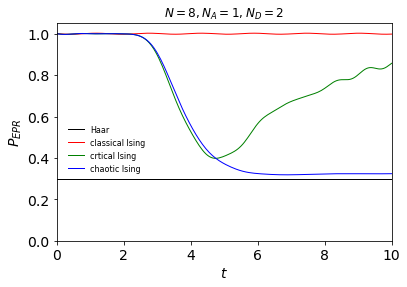

In [13]:
plt.plot(time_cl,P_haar(NA,ND)+0*time_cl,linewidth=1,color="black",label="Haar")

plt.plot(time_cl,y_cl,'r-', linewidth=1,label="classical Ising")
plt.plot(time_cr,y_cr,'g-', linewidth=1,label="crtical Ising")
plt.plot(time_ch,y_ch,'b-', linewidth=1,label="chaotic Ising")


plt.xlabel("$t$", fontsize=14)
plt.ylabel(r"$P_{EPR}$", fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim([0.,T])
plt.ylim([0.0,1.05])
plt.title(f"$N={N}, N_A={NA}, N_D={ND}$", fontsize=12) #dt={dt}
legend =plt.legend(bbox_to_anchor=(0, 0.26), loc='lower left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()

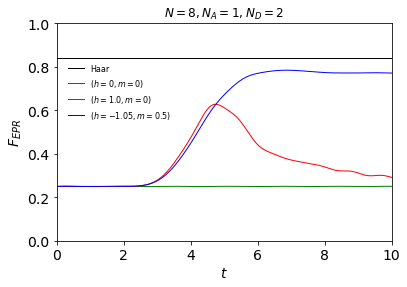

In [15]:
plt.plot(time_cl,F_haar(NA,ND)+0*time_cl,linewidth=1,color="black",label="Haar")

plt.plot(time_cl,1.0/(2**2*y_cl),'g-', linewidth=1,label="classical Ising")
plt.plot(time_cr,1.0/(2**2*y_cr),'r-', linewidth=1,label="crtical Ising")
plt.plot(time_ch,1.0/(2**2*y_ch),'b-',linewidth=1,label="chaotic Ising")

plt.xlabel("$t$", fontsize=14)
plt.ylabel(r"$F_{EPR}$", fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim([0.,T])
plt.ylim([0.,1.0])
plt.title(f"$N={N}, N_A={NA}, N_D={ND}$", fontsize=12) #dt={dt}
legend=plt.legend(bbox_to_anchor=(0, 0.5), loc='lower left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()